<h1><b>Задача по предсказанию рейтинга шоколада

<h3><b>Никнейм на Kaggle: 

# Описание задачи

In [1]:
# Даны характеристики шоколадок и по ним нужно предсказать их рейтинг.

# Описание данных
# Company - компания производитель
# Specific Bean Origin - географический регион происхождения
# REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
# Review - дата публикации отзыва
# Cocoa Percent - процентное содержание какао
# Company Location - страна производитель
# Rating - экспертный рейтинг
# Bean Type - используемый сорт какао-бобов, если таковой имеется
# Broad Bean Origin - географический регион происхождения какао-бобов

# Файлы с данными
# choco_train.csv - тренировочные данные
# choco_test_new.csv - тестовые данные
# choco_sample_submission.csv - пример submission

# Импорт библиотек, константы

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRanker, LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import optuna

In [6]:
import association_metrics as am
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE, mean_absolute_error as MAE, r2_score, mean_squared_error as MSE
from scipy import stats

from sklearn.pipeline import Pipeline

In [7]:
RANDOM_STATE = 42

# Загрузка данных

In [45]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [46]:
train_df = pd.read_csv(TRAIN)

In [47]:
test_df = pd.read_csv(TEST)

In [48]:
train_df['Bean Type'].value_counts().index[0]

'\xa0'

In [49]:
train_df = train_df.replace('\xa0', np.NaN)
test_df = test_df.replace('\xa0', np.NaN)

# Обзор данных

Описание данных
* Company - компания производитель
* Specific Bean Origin - географический регион происхождения
* REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
* Review - дата публикации отзыва
* Cocoa Percent - процентное содержание какао
* Company Location - страна производитель
* Rating - экспертный рейтинг
* Bean Type - используемый сорт какао-бобов, если таковой имеется
* Broad Bean Origin - географический регион происхождения какао-бобов

In [50]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,NaN,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,NaN,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [51]:
train_df.nunique()

Company                 376
Specific Bean Origin    762
REF                     433
Review                   12
Cocoa Percent            40
Company Location         58
Rating                   13
Bean Type                37
Broad Bean Origin        83
dtype: int64

In [52]:
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,NaN,NaN
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


In [53]:
test_df.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                19
Broad Bean Origin        59
dtype: int64

In [54]:
df_concat = pd.concat([train_df, test_df], axis=0)

In [55]:
cols_temp = ['Company', 'Specific Bean Origin', 'Cocoa Percent',
       'Company Location', 'Bean Type', 'Broad Bean Origin']

In [56]:
from association_metrics import CramersV

cramer_df = df_concat[cols_temp]
cramer_df = cramer_df.astype('category')

cramer = CramersV(cramer_df)
cramer = cramer.fit()

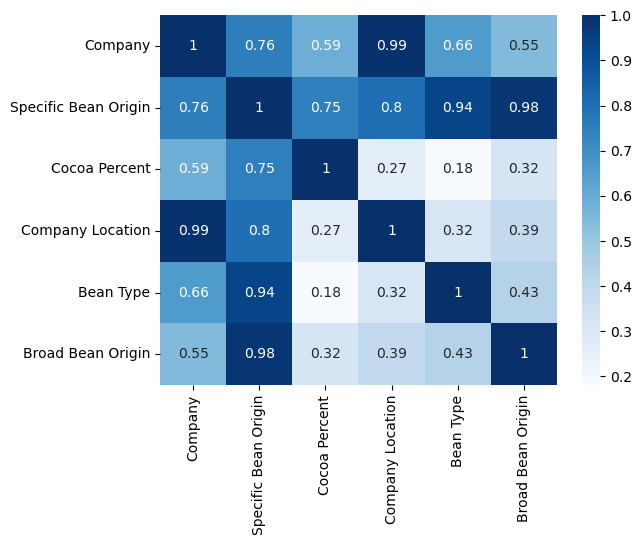

In [57]:
import seaborn as sns

sns.heatmap(cramer, cmap='Blues', annot=True);

In [58]:
def select_top3_corr_cols(col_in):
    select_df = cramer[col_in].sort_values(ascending=False)
    return select_df[1:4].index.to_list()

In [59]:
def get_temp_df(col_in, col_on):
    temp_df = df_concat.groupby(col_on)[col_in] \
                        .agg(lambda x: np.random.choice(x.mode()) if len(x.mode()) > 0 else np.NaN) \
                        .dropna().reset_index()
    return temp_df

In [60]:
def fill_rows(row, col_on, temp_df):
    for variants, category in temp_df.values:
        if row[col_on] == variants:
            return category
    return np.NaN

In [61]:
train_df.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
dtype: int64

In [62]:
def prepared_df(df, col_in):
    selected_cols = select_top3_corr_cols(col_in)
    print(selected_cols)
    for col_on in selected_cols:
        temp_df = get_temp_df(col_in, col_on)
        df[col_in] = df.apply(lambda row: fill_rows(row, col_on, temp_df) if row[col_in] is np.NaN else row[col_in], axis=1)
        df[col_in] = df[col_in].fillna('Other')

In [63]:
cols_in = ['Bean Type', 'Broad Bean Origin']

for col_in in cols_in:
    prepared_df(train_df, col_in)

for col_in in cols_in:
    prepared_df(test_df, col_in)

['Specific Bean Origin', 'Company', 'Broad Bean Origin']
['Specific Bean Origin', 'Company', 'Bean Type']
['Specific Bean Origin', 'Company', 'Broad Bean Origin']
['Specific Bean Origin', 'Company', 'Bean Type']


In [64]:
train_df.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [65]:
train_df = train_df.replace('\xa0', np.NaN)
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
train_df['Review'] = train_df['Review'].astype('object')

test_df = test_df.replace('\xa0', np.NaN)
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
test_df['Review'] = test_df['Review'].astype('object')

In [66]:
# Словарь маппинга для разновидностей какао сорта
cacao_map = {
'Criollo': ['Criollo', 'Criollo (Porcelana)', 'Criollo (Amarru)', 'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)',
'Criollo (Ocumare 61)', 'Criollo (Ocumare)', 'Criollo (Wild)', 'Criollo, +'],
'Trinitario': ['Trinitario', 'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Trinitario (85% Criollo)'],
'Forastero': ['Forastero', 'Forastero (Arriba)', 'Forastero (Arriba) ASS', 'Forastero (Arriba) ASSS',
'Forastero (Nacional)', 'Forastero (Parazinho)', 'Forastero (Catongo)', 'Forastero (Amelonado)'],
'Nacional': ['Nacional', 'Nacional (Arriba)'],
'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
'Blend': ['Criollo, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero', 'Forastero, Trinitario',
'Trinitario, Nacional', 'Criollo, Forastero', 'Blend-Forastero,Criollo', 'Blend']
}

# Функция для маппинга типов какао
def map_cacao_type(value):
    for category, variants in cacao_map.items():
        if value in variants:
            return category
    return value

In [67]:
train_df['Bean Type'] = train_df['Bean Type'].apply(map_cacao_type)
test_df['Bean Type'] = test_df['Bean Type'].apply(map_cacao_type)

In [68]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,Other,Venezuela
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,Criollo,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,Criollo,Indonesia


In [69]:
train_df.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                   object
Cocoa Percent           float16
Company Location         object
Rating                  float64
Bean Type                object
Broad Bean Origin        object
dtype: object

In [70]:
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

In [71]:
X = train_df[cols]
target = train_df['Rating']
test = test_df[cols]

In [72]:
mm_scaler = MinMaxScaler()
scaler = StandardScaler()

X['REF'] = mm_scaler.fit_transform(X[['REF']])  
test['REF'] = mm_scaler.transform(test[['REF']])

In [73]:
mm_scaler = MinMaxScaler()

X['Cocoa Percent'] = mm_scaler.fit_transform(X[['Cocoa Percent']])  
test['Cocoa Percent'] = mm_scaler.transform(test[['Cocoa Percent']])

In [74]:
# label_enc = LabelEncoder()
# temp_df = pd.concat([X, test], axis=0)
# label_enc.fit(temp_df['Bean Type'])
# X['Bean Type'] = label_enc.transform(X['Bean Type'])  
# test['Bean Type'] = label_enc.transform(cleaned_test['Bean Type'])

In [75]:
X

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,0.232152,2009,0.481934,U.K.,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",0.258346,2010,0.481934,Switzerland,Other,Venezuela
2,Dark Forest,Tanzania,0.795583,2015,0.444824,U.S.A.,Criollo,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,0.575244,2013,0.481934,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",0.013867,2006,0.537598,France,Criollo,Indonesia
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,0.183873,2009,0.630371,U.K.,Blend,Madagascar
1251,Marana,Cusco,0.965074,2016,0.444824,Peru,Other,Peru
1252,Arete,Nacional,0.785311,2015,0.407715,U.S.A.,Forastero,Peru
1253,Fresco,"Conacado, #212, LR, SC",0.327170,2011,0.481934,U.S.A.,Other,Dominican Republic


In [76]:
X.dtypes

Company                  object
Specific Bean Origin     object
REF                     float64
Review                   object
Cocoa Percent           float16
Company Location         object
Bean Type                object
Broad Bean Origin        object
dtype: object

In [77]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

## Обучение и подбор гиперпараметров

In [78]:
def objective_catboost(trial):
    max_depth = 4 #trial.suggest_int("max_depth", 3, 5)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.2, log=True)
    n_estimators = trial.suggest_int("n_estimators", 1200, 2000)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 10)
    random_strength = trial.suggest_float("random_strength", 0, 10)
    bagging_temperature = trial.suggest_float("bagging_temperature", 0, 1)
    # border_count = trial.suggest_int("border_count", 32, 255)

    model = CatBoostRegressor(
        cat_features=cat_features,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        # border_count=border_count,
        silent=True
    )

    score = cross_val_score(model, X, target, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=150, n_jobs=-1)

[I 2025-05-12 11:20:56,692] A new study created in memory with name: no-name-52800a5b-b5ff-4e39-b6a2-0febb2750f25
[I 2025-05-12 11:21:18,443] Trial 2 finished with value: 0.18340933897942316 and parameters: {'learning_rate': 0.0069235289398980856, 'n_estimators': 1224, 'l2_leaf_reg': 9.131082688526364, 'random_strength': 3.6783319524930347, 'bagging_temperature': 0.5139548177005273}. Best is trial 2 with value: 0.18340933897942316.
[I 2025-05-12 11:21:20,648] Trial 4 finished with value: 0.18551935053418578 and parameters: {'learning_rate': 0.00493979072793721, 'n_estimators': 1293, 'l2_leaf_reg': 9.67719810465064, 'random_strength': 1.1239424840529877, 'bagging_temperature': 0.8668655002620825}. Best is trial 4 with value: 0.18551935053418578.
[I 2025-05-12 11:21:24,028] Trial 0 finished with value: 0.20034623496239642 and parameters: {'learning_rate': 0.009087639468753116, 'n_estimators': 1492, 'l2_leaf_reg': 6.828753601957062, 'random_strength': 4.731354059173162, 'bagging_temperatu

In [79]:
params = study.best_params
model = CatBoostRegressor(
        cat_features=cat_features,
        max_depth=4,
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        l2_leaf_reg=params['l2_leaf_reg'],
        random_strength=params['random_strength'],
        bagging_temperature=params['bagging_temperature'],
        # border_count=params['border_count'],
        silent=True
    )
model.fit(X, target)

In [80]:
pred = model.predict(test)

In [81]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = pred

result[['id','Rating']].to_csv("choko_submission_18.csv", index=False)